In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.optim as optim

from torch_geometric.utils import from_networkx, to_networkx
import networkx as nx

import pytorch_lightning as pl
from pytorch_lightning import LightningDataModule, LightningModule, Trainer
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint, Callback, TQDMProgressBar
from pytorch_lightning.loggers import WandbLogger



from typing import Callable, Optional

In [3]:
import sys
sys.path.insert(0,'..')

In [4]:
from utils.heterophilic import get_dataset, get_fixed_splits, WebKB, Actor
from project.sheaf_datamodule import SheafDataset_ForGraphs, SheafDataModule_ForGraphs
from project.sheaf_learner import coboundary_learner_on_graph_signal
from project.sheaf_diffusion import sheaf_diffusion
from project.sheaf_simultaneous_sparse import sheaf_gradient_flow
from project.sheaf_simultaneous_potential import sheaf_gradient_flow_potential
from project.sheaf_simultaneous_functor_edgewise  import sheaf_gradient_flow_functor

In [5]:
dataset = get_dataset('texas')
data = dataset[0]
data = get_fixed_splits(data, 'texas', 0)

In [6]:
graph = to_networkx(data)

In [7]:
graph.degree(1)

2

In [8]:
list(graph.neighbors(56)).index(12)

5

In [9]:
list(graph.neighbors(12)).index(56)

0

In [10]:
len(list(graph.neighbors(56)))

104

In [11]:
A = nx.to_numpy_array(graph)

In [12]:
mask = {'train_mask':data.train_mask, 
        'val_mask':data.val_mask, 
        'test_mask':data.test_mask
       }

In [13]:
#    def __init__(self, graph, Nv, dv, Ne, de, adjacency, max_deg, layers, input_dim, output_dim, channels, left_weights, right_weights, potential, mask, use_act, augmented, add_lp, add_hp, dropout, input_dropout, free_potential, first_hidden, second_hidden, learning_rate = 0.01):

model_diffusion = sheaf_gradient_flow_functor(graph, 183, 2, graph.number_of_edges(), 2, A, 104, 4, 1703,5, 3, True, True, 'radial', mask, True,True,True,True, 0.02,0.0,True, 200, 200, 0.0001)
#model_diffusion = sheaf_gradient_flow_potential(graph, 183, 3, graph.number_of_edges(), 3, 2, 1703,5, 4, True, True, 'radial', mask, True,True,True,True, 0.6,0.6, 0.0001)

In [14]:
#model_diffusion

In [15]:
wandb_logger_diffusion = WandbLogger(project="sheaf_learning_diffusion_with_coboundary_edgewise_functor")

wandb: Currently logged in as: saepark. Use `wandb login --relogin` to force relogin


In [17]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=0.001, patience=20, verbose=False)
checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",
    dirpath="/root/projects/temp_checkpoints",
    filename="test-sheaffunctoredge-{epoch:02d}-{val_loss:.2f}",
    save_top_k=4,
    mode="min",
)
class PrintCallbacks(Callback):
    def on_init_start(self, trainer):
        print("Starting to init trainer!")

    def on_init_end(self, trainer):
        print("Trainer is init now")

    def on_train_end(self, trainer, pl_module):
        print("Training ended")


In [18]:
sheaf_dm = SheafDataModule_ForGraphs(data, 60 , 1)

In [19]:
trainer = Trainer(accelerator='gpu',callbacks=[TQDMProgressBar(refresh_rate=10),PrintCallbacks(),early_stop_callback,checkpoint_callback],logger=wandb_logger_diffusion,auto_lr_find=True)

Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


In [20]:
A = torch.rand(100)

In [21]:
A.reshape(2,2,-1).size()

torch.Size([2, 2, 25])

In [22]:
lr_finder = trainer.tuner.lr_find(model_diffusion, sheaf_dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=73` reached.
LR finder stopped early after 73 steps due to diverging loss.
Restoring states from the checkpoint path at /root/projects/sheaf-learn-project/notebooks/.lr_find_b700914d-df60-49bb-9ebc-c3ddfee18c7b.ckpt


In [23]:
model_diffusion

sheaf_gradient_flow_functor(
  (graph_to_sheaf): Linear(in_features=3406, out_features=200, bias=True)
  (graph_to_sheaf2): Linear(in_features=200, out_features=200, bias=True)
  (graph_to_sheaf3): Linear(in_features=200, out_features=32, bias=True)
  (self_energy_channel_mixing): Linear(in_features=3, out_features=3, bias=True)
  (self_energy_stalk_mixing): Linear(in_features=4, out_features=4, bias=True)
  (diffusion_stalk_mixing): Linear(in_features=4, out_features=4, bias=True)
  (diffusion_channel_mixing): Linear(in_features=3, out_features=3, bias=True)
  (lin_left_weights): ModuleList(
    (0): Linear(in_features=4, out_features=4, bias=False)
    (1): Linear(in_features=4, out_features=4, bias=False)
    (2): Linear(in_features=4, out_features=4, bias=False)
    (3): Linear(in_features=4, out_features=4, bias=False)
  )
  (lin_right_weights): ModuleList(
    (0): Linear(in_features=3, out_features=3, bias=False)
    (1): Linear(in_features=3, out_features=3, bias=False)
    (2)

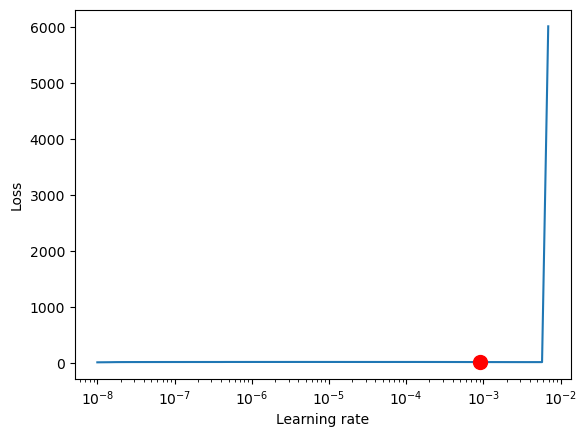

In [24]:
fig = lr_finder.plot(suggest=True)
fig.show()

In [25]:
new_lr = lr_finder.suggestion()
model_diffusion.hparams.learning_rate = 1e-4
model_diffusion.learning_rate = 1e-4
#model_diffusion.hparams.learning_rate = new_lr
#model_diffusion.learning_rate = new_lr

In [26]:
trainer.fit(model_diffusion, sheaf_dm)

/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint directory /root/projects/temp_checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                       | Type          | Params
-------------

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


In [23]:
torch.diag(1.+5*torch.ones(3))

tensor([[6., 0., 0.],
        [0., 6., 0.],
        [0., 0., 6.]])

wandb: Network error (ReadTimeout), entering retry loop.


In [19]:
import torch
from torch_sparse import coalesce

In [23]:
index = torch.tensor([[1, 0, 1, 0, 2, 1],
                      [0, 1, 1, 1, 0, 0]])
value = torch.Tensor([1,2,3,4,5,6])

index, value = coalesce(index, value, m=3, n=2)

In [24]:
index

tensor([[0, 1, 1, 2],
        [1, 0, 1, 0]])

In [25]:
value

tensor([6., 7., 3., 5.])